In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict as dd
from tqdm import tqdm
import pickle
import json

## Sample games

In [2]:
games_list = os.listdir('../presentables/raw_predicted_scores/')

In [3]:
year = 2024
sqrt_mean_squared_error = 0.087452

In [4]:
all_games_player_distributions = dict()
games_list = [game for game in games_list if game.startswith(str(year))]

In [5]:
train_data = pd.read_csv('../data/curated/modelling/graph_train.csv')

with open('../models/feature_importance_ordering.pickle', 'rb') as f:
    feature_importance_ordering = pickle.load(f)

In [6]:
np.random.seed(0)
n_samples = 50000

In [ ]:
X = train_data[list(list(feature_importance_ordering.keys())[-1])].values

In [ ]:
all_games_simulation = dd(dict)

number_of_games = 0
for game_filename in tqdm(games_list):

    # read in predicted scores
    predicted_game = pd.read_csv(
        f'../presentables/raw_predicted_scores/{game_filename}')

    round_number = game_filename.split('_')[1].split('.')[0]
    team1 = game_filename.split('_')[2].split('v')[0].strip()
    team2 = game_filename.split('v')[1].split('.')[0].strip()

    game_features = pd.read_csv(
        f'../future data/curated/NormalisedData/{year} Round {round_number.strip("round")} {team1} v {team2}  (N).csv')

    x = game_features[list(
        list(feature_importance_ordering.keys())[-1])].values

    diag = np.diag(x @ np.linalg.inv(np.transpose(X) @ X) @ np.transpose(x))

    # simulate game
    n_players = len(predicted_game)
    predicted_scores = predicted_game['predicted_score']
    players = predicted_game['player']

    # simulate the samples
    epsilon = np.random.normal(0, 1, n_players*n_samples)

    all_games_simulation[round_number][team1 + ' v ' + team2] = dict()

    for i in range(n_samples):
        sampled_game_score = predicted_scores + \
            epsilon[i*n_players:(i+1)*n_players] * \
            sqrt_mean_squared_error * np.sqrt(1+diag)
        sampled_game_score.sort_values(ascending=False, inplace=True)

        sampled_player_rank = [players[i] for i in sampled_game_score.index]

        all_games_simulation[round_number][team1 +
                                           ' v ' + team2][str(i)] = sampled_player_rank

In [ ]:
with open(f'../presentables/{year}_simulated_games.json', 'w') as f:
    json.dump(all_games_simulation, f)

#### Research: prob convergence

In [ ]:
def simulation_stability(round_number, team1, team2, player, n_samples, all_games_simulation, **kwargs):

    player_prob = dd(list)

    total = dd(int)

    for i in range(n_samples):
        for j in range(3):
            total[j] += bool(all_games_simulation[round_number][team1 +
                                                                ' v ' + team2][str(i)].index(player) == j)
        total[3] += bool(all_games_simulation[round_number][team1 +
                                                            ' v ' + team2][str(i)].index(player) > 3)

        for j in range(4):
            player_prob[j].append(total[j]/(i+1))

        if i in [9, 99, 999, 9999, 19999, 29999, 39999, 49999, 59999, 69999, 79999, 89999, 99999]:
            print(
                f'Probability of {player} being the top player in {team1} v {team2} is {total[0]/(i+1)} after {i+1} samples')

    plt.title(
        f'Probability of {player} getting x votes in {team1} v {team2}')

    for j in range(4):
        plt.plot(player_prob[j])
        plt.legend(['3 votes', '2 votes', '1 vote', 'no votes'])
    plt.show()


evaluated = 0
for round in all_games_simulation:

    for game in all_games_simulation[round]:

        data = pd.read_csv(
            f'../presentables/raw_predicted_scores/{year}_{round}_{game}.csv')

        simulation_stability(round, game.split(' v ')[0], game.split(
            ' v ')[1], data.loc[0, 'player'], n_samples, all_games_simulation)
        
        if evaluated >=10:
            break
        evaluated += 1
    if evaluated >= 10:
        break

## Collect person prob

In [7]:
leaderboard = pd.read_csv('../presentables/leaderboard.csv')
interested_players = leaderboard['Player'].head(50).tolist()

In [8]:
with open('../odds/2024_sportsbet_odds.json', 'r') as f:
    odds = json.load(f)

def straight_get_player(odds, bet_type, interested_players):
    for player in odds[bet_type]:
        interested_players.add(player)

    return interested_players

def get_combined_player(odds, bet_type, interested_players):
    for bet in odds[bet_type]:
        players = bet.split('/')
        for player in players:
            interested_players.add(player)

    return interested_players

additional_interested_players = set()

for bet_type in ['2024 AFL Brownlow Medal', 'Top 3 Finish (Includes Ineligible)', 'Top 5 Finish (Includes Ineligible)', 'Top 10 Finish (Includes Ineligible)', 'Top 20 Finish (Includes Ineligible)', 'Leader After Round 6', 'Leader After Round 10', 'Leader After Round 15', 'Most Votes Last 8 Rounds', 'Most 3 Vote Games', 'Player to Poll in the Most Games', 'Brownlow Group - Group A', 'Brownlow Group - Group B', 'Brownlow Group - Group C', 'Brownlow Group - Group D']:
    additional_interested_players = straight_get_player(odds, bet_type, additional_interested_players)

for bet_type in ['Brownlow Medal Quinella', 'Brownlow Medal Exacta', 'Brownlow Medal Trifecta', 'Brownlow Medal Boxed Trifecta', 'Brownlow Medal Pick4', 'Brownlow Medal Boxed Pick4']:
    additional_interested_players = get_combined_player(odds, bet_type, additional_interested_players)

for bet_type in ['To poll 10 or more votes', 'To poll 15 or more votes', 'To poll 20 or more votes', 'To poll 25 or more votes', 'To poll 30 or more votes', 'To Poll a Vote']:
    additional_interested_players = straight_get_player(odds, bet_type, additional_interested_players)

interested_players = list(set(interested_players).union(additional_interested_players))

In [9]:
with open(f'../presentables/{year}_simulated_games.json', 'r') as f:
    all_games_simulation = json.load(f)

In [10]:
np.random.seed(0)
all_games_player_distributions = dd(dict)

for round in tqdm(all_games_simulation):

    for game in all_games_simulation[round]:

        # indep distribution
        all_games_player_distributions[round][game] = dd(dict)

        for player in all_games_simulation[round][game][str(0)]:

            if player not in interested_players:  # get independent distribution
                player_distribution = {i: 0 for i in range(4)}

                for i in range(n_samples):
                    rank = all_games_simulation[round][game][str(i)].index(player)
                    rank = rank if rank < 3 else 3
                    player_distribution[3-rank] += 1

                for i in range(4):
                    player_distribution[i] /= n_samples

                all_games_player_distributions[round][game][player] = player_distribution

        # joint distribution
        game_interested_players_index = {}
        n = 0
        for player in all_games_simulation[round][game][str(0)]:
            if player in interested_players:
                game_interested_players_index[player] = n
                n += 1

        players_distribution = dd(int)
        for i in range(n_samples):
            combo = []
            for player in game_interested_players_index:
                rank = all_games_simulation[round][game][str(i)].index(player)
                rank = rank if rank < 3 else 3
                combo.append((player, 3-rank))
            players_distribution[tuple(combo)] += 1
        for combo in players_distribution:
            players_distribution[combo] /= n_samples

        all_games_player_distributions[round][game]['joint'] = players_distribution

100%|██████████| 25/25 [04:42<00:00, 11.31s/it]


#### Research: Joint distribution stability

Probability of being the first combo in Carlton v Collingwood is 0.1 after 10 samples, 9 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.01 after 100 samples, 68 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.004 after 1000 samples, 309 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.0047 after 10000 samples, 823 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.0039 after 20000 samples, 1055 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.0034666666666666665 after 30000 samples, 1185 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.003325 after 40000 samples, 1270 pos prob instances, 24
Probability of being the first combo in Carlton v Collingwood is 0.00334 after 50000 samples, 1346 pos prob instances, 24


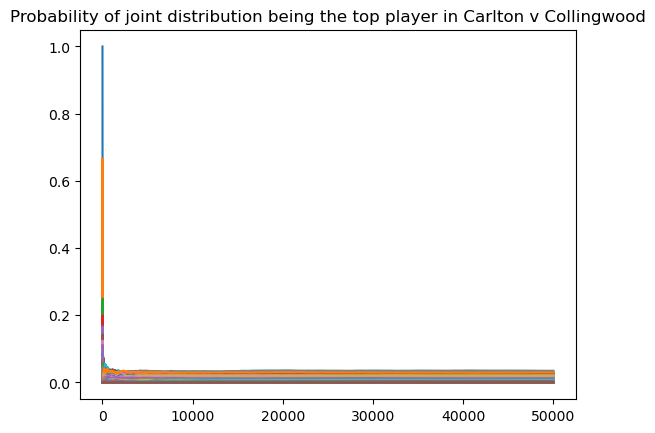

Probability of being the first combo in Sydney v GWS is 0.1 after 10 samples, 9 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.02 after 100 samples, 84 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.004 after 1000 samples, 381 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.0028 after 10000 samples, 739 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.00245 after 20000 samples, 818 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.0024 after 30000 samples, 860 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.0025 after 40000 samples, 891 pos prob instances, 26
Probability of being the first combo in Sydney v GWS is 0.00244 after 50000 samples, 913 pos prob instances, 26


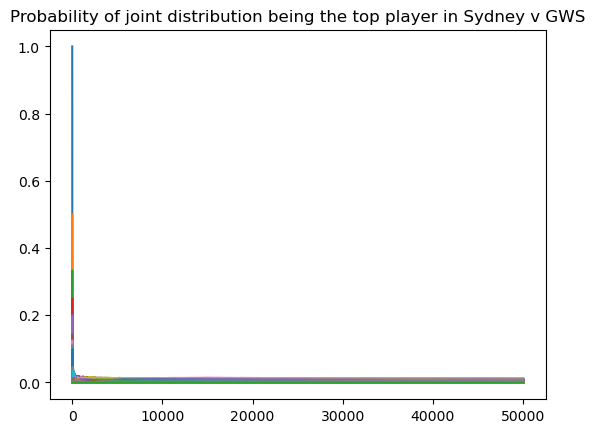

Probability of being the first combo in Richmond v Fremantle is 0.1 after 10 samples, 10 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.01 after 100 samples, 70 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.004 after 1000 samples, 209 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.0074 after 10000 samples, 414 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.00665 after 20000 samples, 477 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.0066 after 30000 samples, 507 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.006675 after 40000 samples, 533 pos prob instances, 18
Probability of being the first combo in Richmond v Fremantle is 0.00646 after 50000 samples, 553 pos prob instances, 18


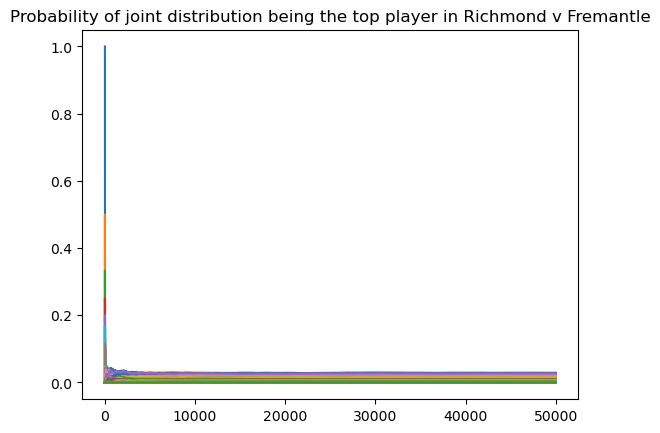

Probability of being the first combo in StKilda v NorthMelbourne is 0.1 after 10 samples, 10 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 0.01 after 100 samples, 71 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 0.001 after 1000 samples, 258 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 0.0002 after 10000 samples, 625 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 0.0001 after 20000 samples, 758 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 6.666666666666667e-05 after 30000 samples, 836 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 5e-05 after 40000 samples, 888 pos prob instances, 20
Probability of being the first combo in StKilda v NorthMelbourne is 6e-05 after 50000 samples, 926 pos prob instances, 20


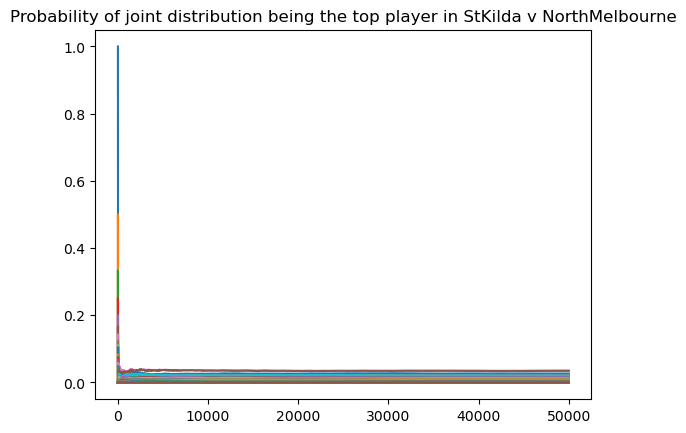

Probability of being the first combo in WestCoast v Essendon is 0.1 after 10 samples, 9 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.01 after 100 samples, 54 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.036 after 1000 samples, 119 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.0351 after 10000 samples, 209 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.0351 after 20000 samples, 241 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.0353 after 30000 samples, 267 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.036075 after 40000 samples, 283 pos prob instances, 18
Probability of being the first combo in WestCoast v Essendon is 0.03734 after 50000 samples, 302 pos prob instances, 18


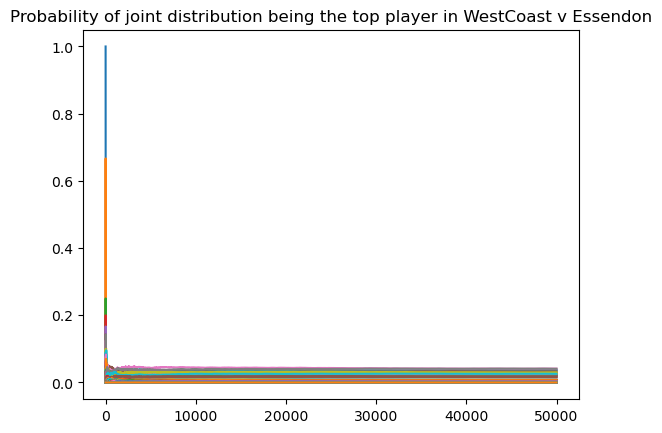

Probability of being the first combo in Adelaide v PortAdelaide is 0.1 after 10 samples, 9 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.01 after 100 samples, 38 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.007 after 1000 samples, 123 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.0022 after 10000 samples, 224 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.00165 after 20000 samples, 271 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.0015 after 30000 samples, 302 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.0014 after 40000 samples, 326 pos prob instances, 24
Probability of being the first combo in Adelaide v PortAdelaide is 0.00136 after 50000 samples, 340 pos prob instances, 24


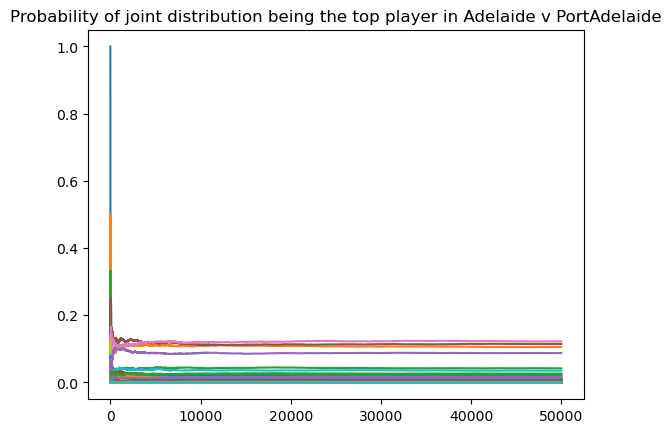

Probability of being the first combo in WesternBulldogs v Hawthorn is 0.1 after 10 samples, 10 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.01 after 100 samples, 75 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.003 after 1000 samples, 303 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.0025 after 10000 samples, 611 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.00265 after 20000 samples, 705 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.0024 after 30000 samples, 757 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.002425 after 40000 samples, 794 pos prob instances, 20
Probability of being the first combo in WesternBulldogs v Hawthorn is 0.00254 after 50000 samples, 825 pos prob instances, 20


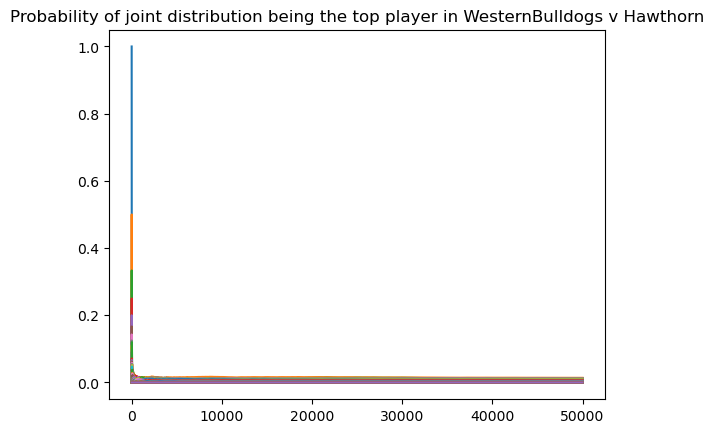

Probability of being the first combo in Melbourne v Geelong is 0.1 after 10 samples, 9 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.02 after 100 samples, 67 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.015 after 1000 samples, 252 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.015 after 10000 samples, 495 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.01525 after 20000 samples, 558 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.015466666666666667 after 30000 samples, 603 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.0153 after 40000 samples, 635 pos prob instances, 23
Probability of being the first combo in Melbourne v Geelong is 0.01514 after 50000 samples, 659 pos prob instances, 23


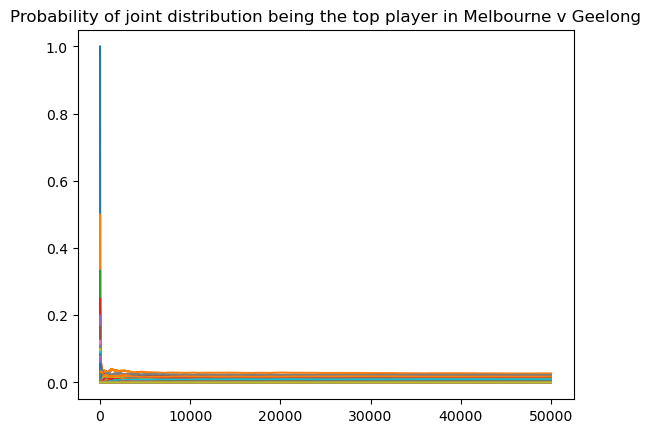

Probability of being the first combo in Brisbane v GoldCoast is 0.1 after 10 samples, 8 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.01 after 100 samples, 63 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.016 after 1000 samples, 239 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.013 after 10000 samples, 560 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.01365 after 20000 samples, 699 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.0135 after 30000 samples, 775 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.014 after 40000 samples, 841 pos prob instances, 23
Probability of being the first combo in Brisbane v GoldCoast is 0.01392 after 50000 samples, 886 pos prob instances, 23


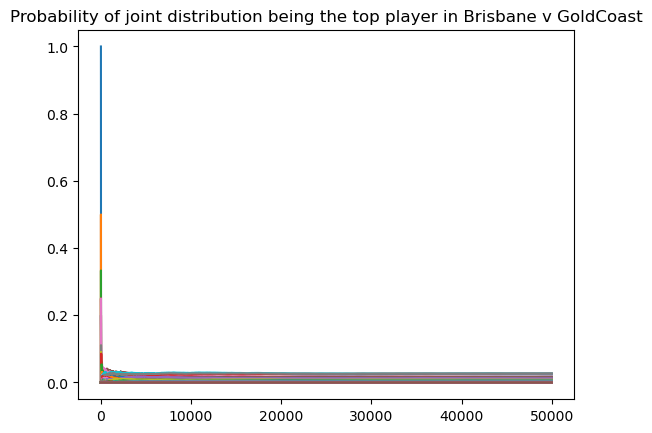

Probability of being the first combo in Richmond v StKilda is 0.1 after 10 samples, 8 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.01 after 100 samples, 48 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.012 after 1000 samples, 133 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.0104 after 10000 samples, 295 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.00945 after 20000 samples, 338 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.009 after 30000 samples, 366 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.008375 after 40000 samples, 384 pos prob instances, 16
Probability of being the first combo in Richmond v StKilda is 0.00836 after 50000 samples, 401 pos prob instances, 16


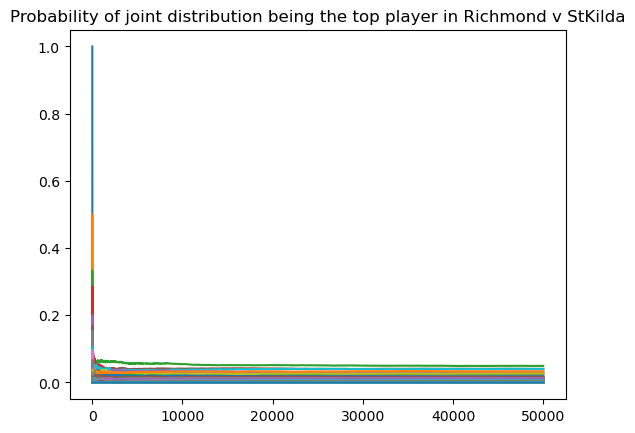

Probability of being the first combo in Fremantle v Carlton is 0.1 after 10 samples, 9 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.01 after 100 samples, 85 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.001 after 1000 samples, 492 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.0004 after 10000 samples, 1430 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.0002 after 20000 samples, 1767 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.00016666666666666666 after 30000 samples, 1971 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.000175 after 40000 samples, 2104 pos prob instances, 26
Probability of being the first combo in Fremantle v Carlton is 0.00016 after 50000 samples, 2218 pos prob instances, 26


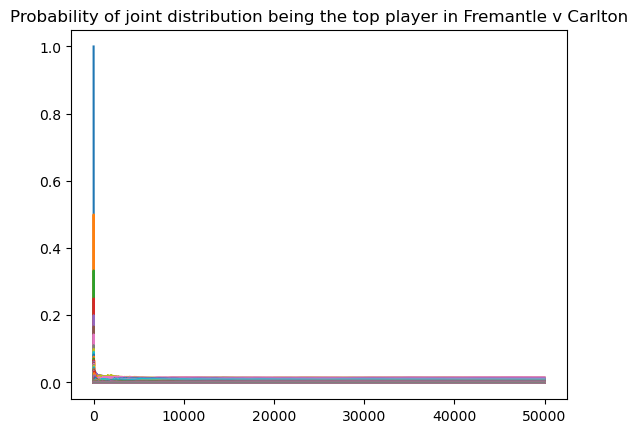

In [ ]:
def simulation_stability_joint(round_number, team1, team2, n_samples, all_games_simulation, **kwargs):

    player_prob = dd(list)

    game_interested_players_index = {}
    n = 0
    for player in all_games_simulation[round][game][str(0)]:
        if player in interested_players:
            game_interested_players_index[player] = n
            n += 1

    total = dd(int)

    for i in range(n_samples):

        combo = []
        for player in game_interested_players_index:
            rank = all_games_simulation[round][game][str(i)].index(player)
            rank = rank if rank < 3 else 3
            combo.append((player, 3-rank))
        total[tuple(combo)] += 1

        if tuple(combo) not in player_prob:
            player_prob[tuple(combo)] = [0 for _ in range(i)]
        player_prob[tuple(combo)].append(total[tuple(combo)]/(i+1))

        for other_combo in player_prob:
            if other_combo != tuple(combo):
                player_prob[tuple(other_combo)].append(
                    player_prob[tuple(other_combo)][-1] * i / (i+1))

        if i in [9, 99, 999, 9999, 19999, 29999, 39999, 49999, 59999, 69999, 79999, 89999, 99999]:
            print(
                f'Probability of being the first combo in {team1} v {team2} is {total[list(total.keys())[0]]/(i+1)} after {i+1} samples, {len(total)} pos prob instances, {len(game_interested_players_index)}')

    plt.title(
        f'Probability of joint distribution being the top player in {team1} v {team2}')

    for combo in player_prob:
        plt.plot(player_prob[combo])
    plt.show()

evaluated = 0
for round in all_games_simulation:

    for game in all_games_simulation[round]:

        data = pd.read_csv(
            f'../presentables/raw_predicted_scores/{year}_{round}_{game}.csv')

        simulation_stability_joint(round, game.split(' v ')[0], game.split(
            ' v ')[1], n_samples, all_games_simulation)
        
        if evaluated >= 10:
            break
        evaluated += 1
    if evaluated >= 10:
        break

# Odds

In [11]:
banned = ['Issac Heeney', 'Dan Houston', 'Izak Rankine']
n_sample_season = 100000

In [16]:
import time

In [17]:
used_time = 0

overall_start_time = time.time()
np.random.seed(0)
simulation_result = dd(list)
game_by_game_simulation_result = dict()

for _ in tqdm(range(n_sample_season)):
    game_by_game_simulation_result[_] = dict()
    overall_tally = {'overall': dd(int), 'Leader After Round 6': dd(int), 'Leader After Round 10': dd(int), 'Leader After Round 15': dd(int), 'Most Votes Last 8 Rounds': dd(int), 'Most 3 Vote Games': dd(int), 'Player to Poll in the Most Games': dd(int)}

    for round_i in range(25):
        game_by_game_simulation_result[_][f'round{round_i}'] = dict()
        round = f'round{round_i}'
        for game in all_games_player_distributions[round]:
            game_by_game_simulation_result[_][f'round{round_i}'][game] = dict()
            # joint

            start_time = time.time()
            sampled_combo = np.random.choice(
                range(len(all_games_player_distributions[round][game]['joint'])), p=list(all_games_player_distributions[round][game]['joint'].values()))
            end_time = time.time()
            used_time += end_time - start_time

            sampled_votes = list(all_games_player_distributions[round][game]['joint'].keys())[sampled_combo]

            for player in sampled_votes:
                overall_tally['overall'][player[0]] += player[1]

                if player[1] > 0:
                    game_by_game_simulation_result[_][f'round{round_i}'][game][player[0]] = player[1]

                if round_i <= 15:
                    overall_tally['Leader After Round 15'][player[0]] += player[1]
                if round_i <= 10:
                    overall_tally['Leader After Round 10'][player[0]] += player[1]
                if round_i <= 6:
                    overall_tally['Leader After Round 6'][player[0]] += player[1]
                if round_i >= 17:
                    overall_tally['Most Votes Last 8 Rounds'][player[0]] += player[1]

                if player[1] == 3:
                    overall_tally['Most 3 Vote Games'][player[0]] += 1
                if player[1] >= 1:
                    overall_tally['Player to Poll in the Most Games'][player[0]] += 1

            # independent
            for player in all_games_player_distributions[round][game]:

                if player == 'joint':
                    continue
                elif all_games_player_distributions[round][game][player][0] >= 0.99:
                    continue
                start_time = time.time()
                sampled_rank = np.random.choice(
                    range(4), p=list(all_games_player_distributions[round][game][player].values()))
                end_time = time.time()
                used_time += end_time - start_time
                overall_tally['overall'][player] += sampled_rank

                if sampled_rank > 0:
                    game_by_game_simulation_result[_][f'round{round_i}'][game][player] = sampled_rank

                if round_i <= 15:
                    overall_tally['Leader After Round 15'][player] += sampled_rank
                if round_i <= 10:
                    overall_tally['Leader After Round 10'][player] += sampled_rank
                if round_i <= 6:
                    overall_tally['Leader After Round 6'][player] += sampled_rank
                if round_i >= 17:
                    overall_tally['Most Votes Last 8 Rounds'][player] += sampled_rank

                if sampled_rank == 3:
                    overall_tally['Most 3 Vote Games'][player] += 1
                if sampled_rank >= 1:
                    overall_tally['Player to Poll in the Most Games'][player] += 1


    # TOP 1, 3, 5, 10, 20
    sorted_votes = {'overall': sorted(overall_tally['overall'].items(), key=lambda x: x[1], reverse=True)}
    sorted_votes['group_A'] = [player for player in sorted_votes['overall'] if player[0] in odds['Brownlow Group - Group A']]
    sorted_votes['group_B'] = [player for player in sorted_votes['overall'] if player[0] in odds['Brownlow Group - Group B']]
    sorted_votes['group_C'] = [player for player in sorted_votes['overall'] if player[0] in odds['Brownlow Group - Group C']]
    sorted_votes['group_D'] = [player for player in sorted_votes['overall'] if player[0] in odds['Brownlow Group - Group D']]

    rank_threshold = {}
    for i in (1, 2, 3, 4, 5, 10, 20):
        rank_threshold[i] = sorted_votes['overall'][i-1][1]
        if i == 1 and sorted_votes['overall'][i-1][0] in banned:
            cont = True
            while cont:
                i += 1
                if sorted_votes['overall'][i-1][0] not in banned:
                    cont = False
                    rank_threshold[i] = sorted_votes['overall'][i-1][1]
                else:
                    pass

    for player in odds['2024 AFL Brownlow Medal']:

        simulation_result[f'2024 AFL Brownlow Medal: {player}'].append(int(overall_tally['overall'][player] >= rank_threshold[1]))

    for i in (3, 5, 10, 20):
        for player in odds[f'Top {i} Finish (Includes Ineligible)']:
            simulation_result[f'Top {i} Finish (Includes Ineligible): {player}'].append(int(overall_tally['overall'][player] >= rank_threshold[i]))
    
    index = {'Brownlow Medal Quinella':2, 'Brownlow Medal Boxed Trifecta': 3, 'Brownlow Medal Boxed Pick4':4}
    for bet in ['Brownlow Medal Quinella', 'Brownlow Medal Boxed Trifecta', 'Brownlow Medal Boxed Pick4']:

        winner = []
        for outcome in odds[bet]:
            players = outcome.split('/')
            
            won = True
            for player in players:
                if overall_tally['overall'][player] < rank_threshold[index[bet]]:
                    won = False
                    break
            
            
            simulation_result[f'{bet}: {outcome}'].append(int(won))

            if won:
                winner.append(outcome)

        # NOTE: we've underestimated dead heat probability - because dead heat minimum odds is 1, not 0.5 * real odds - 1
        for player in winner:
            simulation_result[f'{bet}: {player}'][-1] = 1/len(winner) 
        

    # LEADER AFTER...
    for bet in ['Leader After Round 6', 'Leader After Round 10', 'Leader After Round 15', 'Most Votes Last 8 Rounds']:
        sorted_votes[bet] = sorted(overall_tally[bet].items(), key=lambda x: x[1], reverse=True)
        threshold = sorted_votes[bet][0][1]
        winner = []
        for player in odds[bet]:
            won = int(overall_tally[bet][player] >= threshold)
            simulation_result[f'{bet}: {player}'].append(won)

            if won:
                winner.append(player)
        
        for player in winner:
            simulation_result[f'{bet}: {player}'][-1] = simulation_result[f'{bet}: {player}'][-1]/len(winner)

    # GROUP A B C D
    for group in ['A', 'B', 'C', 'D']:
        group_winner = []
        group_first_rank_threshold = sorted_votes[f'group_{group}'][0][1]
        for player in odds[f'Brownlow Group - Group {group}']:
            won = int(overall_tally['overall'][player] >= group_first_rank_threshold)

            simulation_result[f'Brownlow Group - Group {group}: {player}'].append(won)

            if won:
                group_winner.append(player)

        for player in group_winner:
            simulation_result[f'Brownlow Group - Group {group}: {player}'][-1] = 1/len(group_winner)

    # MOST 3 VOTE GAMES, MOST GAMES POLLED
    for bet in ['Most 3 Vote Games', 'Player to Poll in the Most Games']:
        sorted_votes[bet] = sorted(overall_tally[bet].items(), key=lambda x: x[1], reverse=True)
        threshold = sorted_votes[bet][0][1]
        winner = []
        for player in odds[bet]:
            won = int(overall_tally[bet][player] >= threshold)
            simulation_result[f'{bet}: {player}'].append(won)

            if won:
                winner.append(player)
        
        # dead heat
        for player in winner:
            simulation_result[f'{bet}: {player}'][-1] = simulation_result[f'{bet}: {player}'][-1]/len(winner)

    # TIE FIRST
    for outcome in odds['Will there be a tie in 2024?']:
        simulation_result[f'Will there be a tie in 2024?: {outcome}'].append(int(outcome == int(sorted_votes['overall'][0][1] == sorted_votes['overall'][1][1])) if 'yes' in outcome.lower() else int(outcome != int(sorted_votes['overall'][0][1] != sorted_votes['overall'][1][1])))

    # WINNING MARGIN
    for outcome in odds['Winning Margin']:
        if outcome == 'Tie':
            continue
        if outcome == '11+ votes':
            margin_min = 11
            margin_max = np.inf
        else:
            margin_min = int(outcome.split(' ')[0])
            margin_max = int(outcome.split(' ')[2])

        simulation_result[f'Winning Margin: {outcome}'].append(int(sorted_votes['overall'][0][1] - sorted_votes['overall'][1][1] <= margin_max and sorted_votes['overall'][0][1] - sorted_votes['overall'][1][1] >= margin_min))
    
    # HANDICAP MARGIN
    overall_tally['handicap'] = overall_tally['overall'].copy()
    for outcome in odds['Elite Player Handicap']:
        
        player = ' '.join(outcome.split(' ')[:2])
        handicap = float(outcome.split(' ')[-1].strip('(+)'))

        overall_tally['handicap'][player] += handicap

    sorted_votes['handicap'] = sorted(overall_tally['handicap'].items(), key=lambda x: x[1], reverse=True)
    rank_threshold[1] = sorted_votes['handicap'][0][1]
    for player_votes in odds['Elite Player Handicap']:
        player = ' '.join(player_votes.split(' ')[:2])
        handicap = player_votes.split(' ')[-1]
        simulation_result[f'Elite Player Handicap: {player} {handicap}'].append(int(overall_tally['handicap'][player] >= rank_threshold[1]))

    for bet in ['To poll 10 or more votes', 'To poll 15 or more votes', 'To poll 20 or more votes', 'To poll 25 or more votes', 'To poll 30 or more votes']:
        vote = int(bet.split(' ')[-4])

    for player in odds[bet]:
        simulation_result[f'{bet}: {player}'].append(int(overall_tally['overall'][player] >= vote))

    for player in odds['To Poll a Vote']:
        simulation_result[f'To Poll a Vote: {player}'].append(int(overall_tally['overall'][player] >= 1))

overall_end_time = time.time()
overall_used_time = overall_end_time - overall_start_time

100%|██████████| 100000/100000 [48:43<00:00, 34.20it/s]   


In [27]:
# get time taken for sampling
print(f'Proportion of time taken for sampling: {used_time/overall_used_time * 100} %')

Proportion of time taken for sampling: 59.03522685907583 %


In [19]:
simulated_results_df = pd.DataFrame(simulation_result)

simulated_prob = simulated_results_df.mean()
simulated_cov = simulated_results_df.cov()

In [20]:
odds_df = pd.DataFrame({'p': simulated_prob})
odds_df['var'] = odds_df['p']*(1-odds_df['p'])/n_sample_season
odds_df['lower_bound_p'] = odds_df['p']-2*np.sqrt(odds_df['var'])

for i in (0.05, 0.1, 0.2):
    odds_df['lower_p_safety_margin_'+str(i)] = odds_df['p']-i

In [21]:
official_odds = []

for bet in odds_df.index:
    player = bet.split(': ')[1]
    bet_type = bet.split(': ')[0]

    official_odds.append(odds[bet_type][player])

In [22]:
odds_df['official_odds'] = official_odds

odds_df['return'] = (odds_df['official_odds']/1)*odds_df['p'] + (-1/1) * (1-odds_df['p'])
odds_df['lower_bound_return'] = odds_df['official_odds']*odds_df['lower_bound_p'] - 1 * (1-odds_df['lower_bound_p'])
for i in (0.05, 0.1, 0.2):
    odds_df['return_safety_margin_'+str(i)] = odds_df['official_odds']*odds_df['lower_p_safety_margin_'+str(i)] - 1 * (1-odds_df['lower_p_safety_margin_'+str(i)])

In [23]:
def get_positive_return_data(odds_df, simulated_corr, prob_type, filter = True):

    # drop no tie in 2024
    odds_df = odds_df[odds_df.index != 'Will there be a tie in 2024?: No there won\'t be a tie']

    if filter:
        positive_return_data =  odds_df[odds_df[prob_type] > 0]
    else:
        positive_return_data = odds_df
    positive_return_bets = positive_return_data.index
    positive_return_Er = positive_return_data[prob_type].values
    positive_return_corr = simulated_corr.loc[positive_return_bets, positive_return_bets].values

    return positive_return_bets, positive_return_Er, positive_return_corr

portfolio_data = {'lower_bound_return': {}, 'return_safety_margin_0.05': {}, 'return_safety_margin_0.1': {}, 'return_safety_margin_0.2': {}}

for prob_type in ['lower_bound_return', 'return_safety_margin_0.05', 'return_safety_margin_0.1', 'return_safety_margin_0.2']:
    positive_return_bets, positive_return_Er, positive_return_corr = get_positive_return_data(odds_df, simulated_cov, prob_type)
    portfolio_data[prob_type]['bets'] = positive_return_bets
    portfolio_data[prob_type]['Er'] = positive_return_Er
    portfolio_data[prob_type]['cov'] = positive_return_corr

unfiltered_portfolio_data = {'lower_bound_return': {}, 'return_safety_margin_0.05': {}, 'return_safety_margin_0.1': {}, 'return_safety_margin_0.2': {}}
for prob_type in ['lower_bound_return', 'return_safety_margin_0.05', 'return_safety_margin_0.1', 'return_safety_margin_0.2']:
    positive_return_bets, positive_return_Er, positive_return_corr = get_positive_return_data(odds_df, simulated_cov, prob_type, filter = False)
    unfiltered_portfolio_data[prob_type]['bets'] = positive_return_bets
    unfiltered_portfolio_data[prob_type]['Er'] = positive_return_Er
    unfiltered_portfolio_data[prob_type]['cov'] = positive_return_corr

In [33]:
import numpy as np
from scipy.optimize import minimize

def portfolio_optimization(mean_returns, cov_matrix, risk_free_rate=0.0, method='max_sharpe'):
    """
    Perform portfolio optimization to either maximize the Sharpe ratio or minimize volatility.
    
    Parameters:
    - mean_returns: A numpy array of mean returns for each asset.
    - cov_matrix: A covariance matrix of asset returns.
    - risk_free_rate: The risk-free rate, default is 0.0.
    - method: Optimization method, 'max_sharpe' to maximize Sharpe ratio or 'min_volatility' to minimize volatility.
    
    Returns:
    - optimal_weights: The optimal asset weights for the portfolio.
    - optimal_return: The expected return of the optimized portfolio.
    - optimal_volatility: The volatility of the optimized portfolio.
    - optimal_sharpe: The Sharpe ratio of the optimized portfolio.
    """
    
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    
    def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe_ratio
    
    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]
    
    def portfolio_volatility(weights, mean_returns, cov_matrix, risk_free_rate):
        return portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[1]
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets,]
    
    if method == 'max_sharpe':
        result = minimize(neg_sharpe_ratio, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    elif method == 'min_volatility':
        result = minimize(portfolio_volatility, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        raise ValueError("Invalid method. Use 'max_sharpe' or 'min_volatility'.")
    
    optimal_weights = result.x
    optimal_return, optimal_volatility, optimal_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix, risk_free_rate)
    
    return optimal_weights, optimal_return, optimal_volatility, optimal_sharpe

# Example usage:
margin_type = 'return_safety_margin_0.2'

mean_returns = portfolio_data[margin_type]['Er']
cov_matrix = portfolio_data[margin_type]['cov']
bet = portfolio_data[margin_type]['bets']
risk_free_rate = 0.049
optimal_weights, optimal_return, optimal_volatility, optimal_sharpe = portfolio_optimization(mean_returns, cov_matrix, risk_free_rate, method='max_sharpe')
display("Optimal Weights:", {bet[i]: np.round(100*optimal_weights[i], 1) for i in range(len(bet))})
print("Expected Return:", 100*optimal_return, "%")
print("Volatility:", 100*optimal_volatility, '%')
print("Sharpe Ratio:", optimal_sharpe)
print("number of bets:", len(bet))

'Optimal Weights:'

{'Top 3 Finish (Includes Ineligible): Marcus Bontempelli': 0.2,
 'Top 3 Finish (Includes Ineligible): Zak Butters': 0.0,
 'Top 5 Finish (Includes Ineligible): Nick Daicos': 0.3,
 'Top 5 Finish (Includes Ineligible): Marcus Bontempelli': 0.0,
 'Top 5 Finish (Includes Ineligible): Zak Butters': 0.7,
 'Top 10 Finish (Includes Ineligible): Lachie Neale': 0.5,
 'Top 10 Finish (Includes Ineligible): Marcus Bontempelli': 0.4,
 'Top 10 Finish (Includes Ineligible): Zak Butters': 0.0,
 'Top 10 Finish (Includes Ineligible): Rowan Marshall': 1.7,
 'Top 10 Finish (Includes Ineligible): Max Gawn': 3.7,
 'Top 10 Finish (Includes Ineligible): Lachie Whitfield': 0.9,
 'Top 20 Finish (Includes Ineligible): Zak Butters': 0.1,
 'Top 20 Finish (Includes Ineligible): Adam Treloar': 0.3,
 'Top 20 Finish (Includes Ineligible): Max Gawn': 0.0,
 'Top 20 Finish (Includes Ineligible): Rowan Marshall': 0.0,
 'Top 20 Finish (Includes Ineligible): Lachie Whitfield': 0.2,
 'Top 20 Finish (Includes Ineligible): Harry

Expected Return: 162.8997113212663 %
Volatility: 3.1093792473418995 %
Sharpe Ratio: 50.81390809961016
number of bets: 124


#### Research: Season stability

In [ ]:
# get cumulative sum of simulated_results_df
cumulative_sum = simulated_results_df.cumsum()

# get each row divided by index value
cum_prob = cumulative_sum.div(range(1, n_sample_season+1), axis=0)

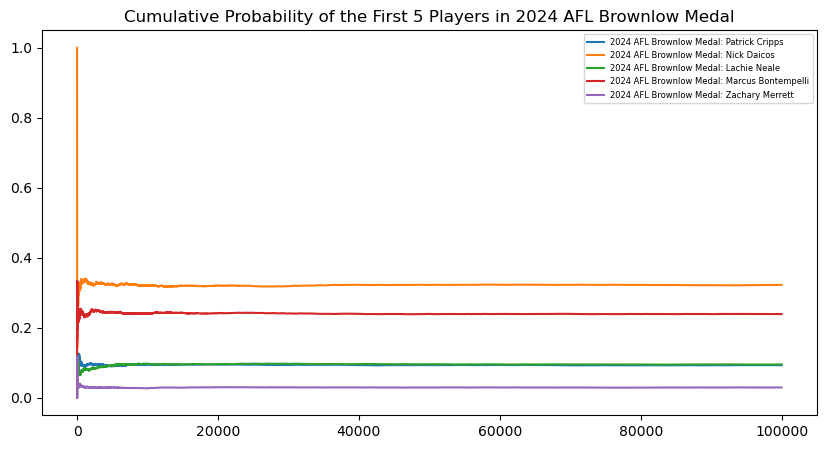

Probability of the first player in 2024 AFL Brownlow Medal is 0.0 after 10 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.11 after 100 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.091 after 1000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.0943 after 10000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.09455 after 20000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.0939 after 30000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.093475 after 40000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.09324 after 50000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.09385 after 60000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.09271428571428571 after 70000 samples
Probability of the first player in 2024 AFL Brownlow Medal is 0.0928125 after 80000 samples
Probability 

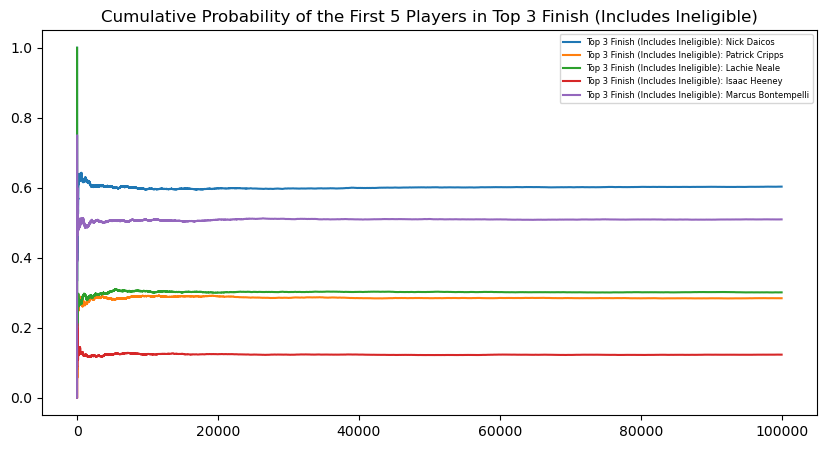

Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.5 after 10 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.51 after 100 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.621 after 1000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.5964 after 10000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.59825 after 20000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.5982 after 30000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.599525 after 40000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.60116 after 50000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.6017 after 60000 samples
Probability of the first player in Top 3 Finish (Includes Ineligible) is 0.6017714285714286 after 70000 samp

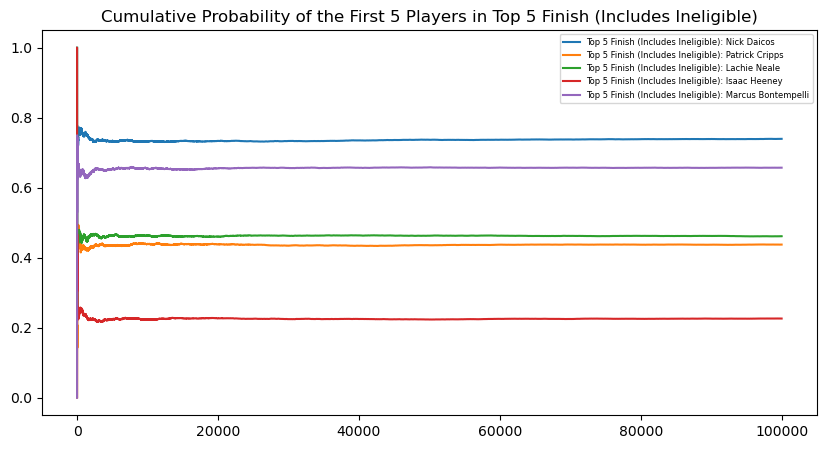

Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.8 after 10 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.73 after 100 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.75 after 1000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.7327 after 10000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.73365 after 20000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.7337 after 30000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.735325 after 40000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.73718 after 50000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.7372 after 60000 samples
Probability of the first player in Top 5 Finish (Includes Ineligible) is 0.7380571428571429 after 70000 sampl

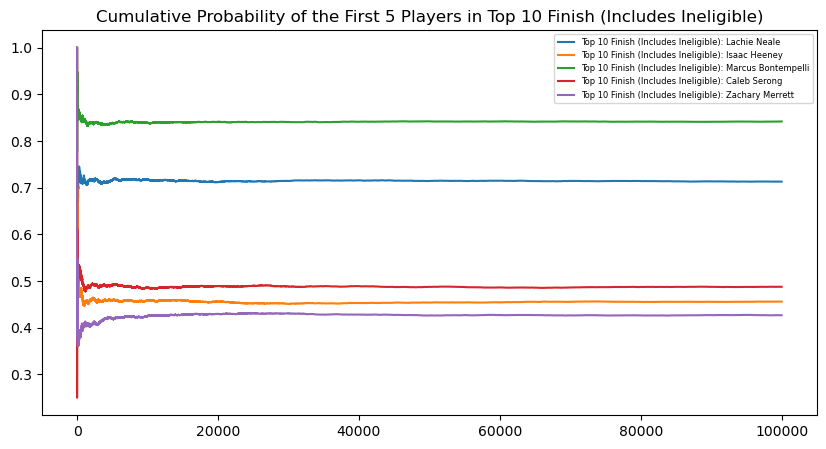

Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.6 after 10 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.68 after 100 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.719 after 1000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.7176 after 10000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.71235 after 20000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.7146 after 30000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.7159 after 40000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.71464 after 50000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.7151 after 60000 samples
Probability of the first player in Top 10 Finish (Includes Ineligible) is 0.7147285714285714 after 70

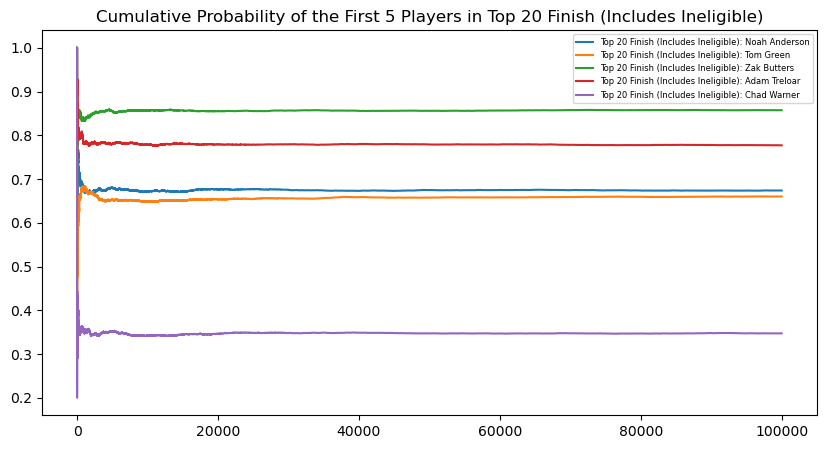

Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.6 after 10 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.71 after 100 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.675 after 1000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.6705 after 10000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.67625 after 20000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.6754333333333333 after 30000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.67295 after 40000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.67474 after 50000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.6750166666666667 after 60000 samples
Probability of the first player in Top 20 Finish (Includes Ineligible) is 0.

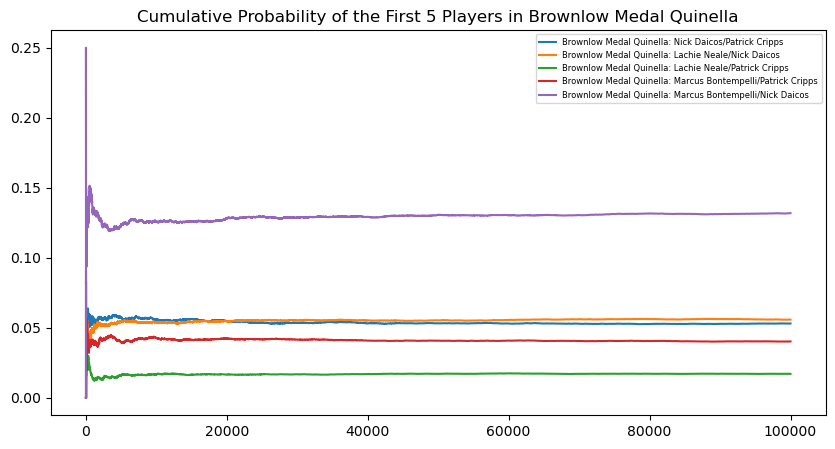

Probability of the first player in Brownlow Medal Quinella is 0.0 after 10 samples
Probability of the first player in Brownlow Medal Quinella is 0.04 after 100 samples
Probability of the first player in Brownlow Medal Quinella is 0.05669999999999999 after 1000 samples
Probability of the first player in Brownlow Medal Quinella is 0.056116230158730136 after 10000 samples
Probability of the first player in Brownlow Medal Quinella is 0.05481319139194153 after 20000 samples
Probability of the first player in Brownlow Medal Quinella is 0.05348592389092366 after 30000 samples
Probability of the first player in Brownlow Medal Quinella is 0.05310723295087238 after 40000 samples
Probability of the first player in Brownlow Medal Quinella is 0.0531448267647388 after 50000 samples
Probability of the first player in Brownlow Medal Quinella is 0.05306066251558962 after 60000 samples
Probability of the first player in Brownlow Medal Quinella is 0.05289453612447388 after 70000 samples
Probability of th

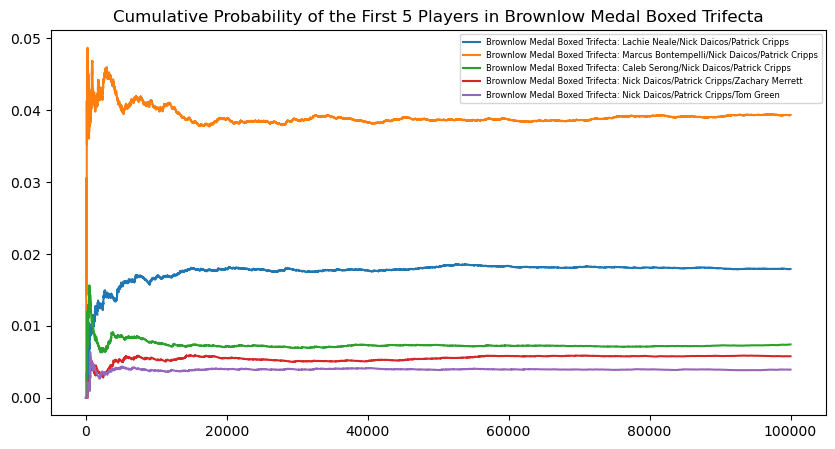

Probability of the first player in Brownlow Medal Boxed Trifecta is 0.0 after 10 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.0025 after 100 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.01036388888888889 after 1000 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.016787898225957054 after 10000 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.01787141876750699 after 20000 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.017767721444133192 after 30000 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.01770249392700222 after 40000 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.018185705947136102 after 50000 samples
Probability of the first player in Brownlow Medal Boxed Trifecta is 0.018332937729055986 after 60000 samples
Probability of the first player in Brownlow Medal Boxed Tri

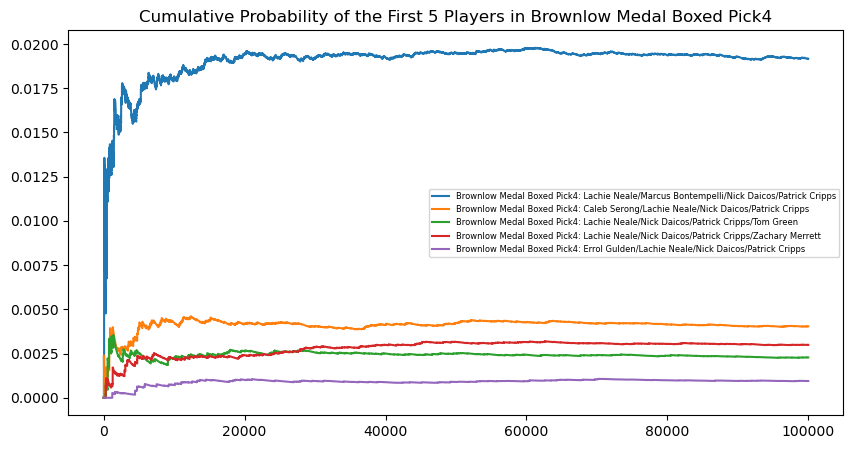

Probability of the first player in Brownlow Medal Boxed Pick4 is 0.0 after 10 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.01302020202020202 after 100 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.012954651780967566 after 1000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.018150162147793712 after 10000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.01943419973954488 after 20000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.019181520365083797 after 30000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.019242574787012166 after 40000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.019496043391941224 after 50000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.019735294882709805 after 60000 samples
Probability of the first player in Brownlow Medal Boxed Pick4 is 0.0194

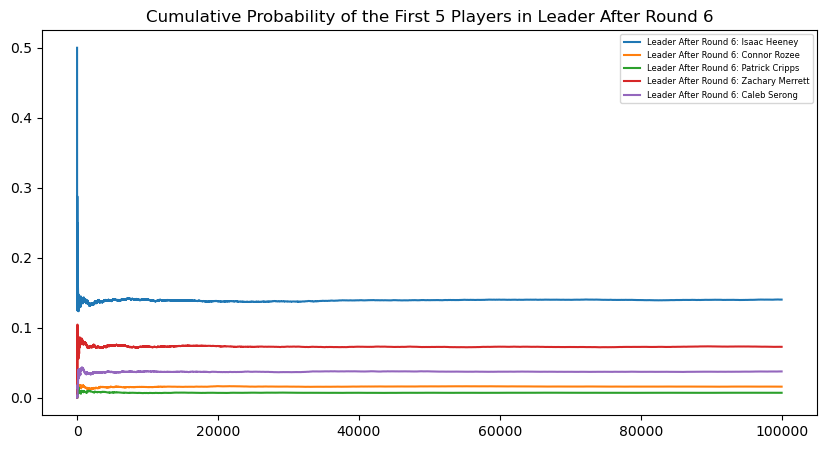

Probability of the first player in Leader After Round 6 is 0.25 after 10 samples
Probability of the first player in Leader After Round 6 is 0.175 after 100 samples
Probability of the first player in Leader After Round 6 is 0.13941666666666663 after 1000 samples
Probability of the first player in Leader After Round 6 is 0.14040357142857138 after 10000 samples
Probability of the first player in Leader After Round 6 is 0.1380332936507938 after 20000 samples
Probability of the first player in Leader After Round 6 is 0.1376014021164028 after 30000 samples
Probability of the first player in Leader After Round 6 is 0.1392296230158723 after 40000 samples
Probability of the first player in Leader After Round 6 is 0.13939607936507778 after 50000 samples
Probability of the first player in Leader After Round 6 is 0.1401518915343898 after 60000 samples
Probability of the first player in Leader After Round 6 is 0.13998019274376405 after 70000 samples
Probability of the first player in Leader After R

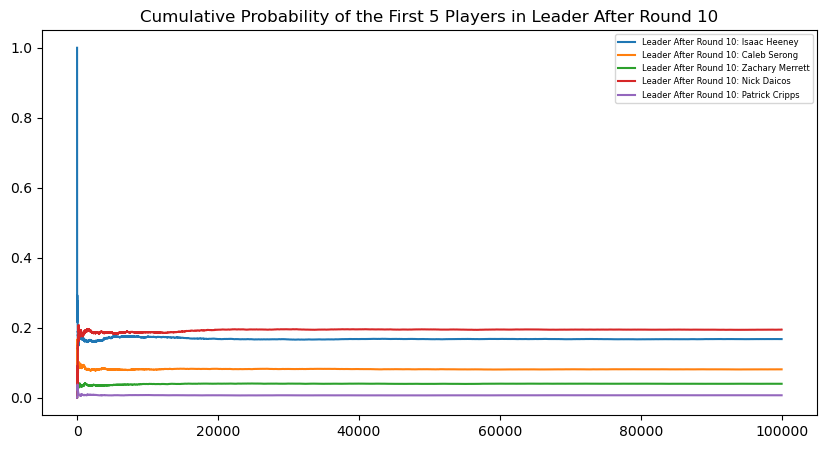

Probability of the first player in Leader After Round 10 is 0.3 after 10 samples
Probability of the first player in Leader After Round 10 is 0.1925 after 100 samples
Probability of the first player in Leader After Round 10 is 0.1644 after 1000 samples
Probability of the first player in Leader After Round 10 is 0.1743033333333331 after 10000 samples
Probability of the first player in Leader After Round 10 is 0.16785964285714328 after 20000 samples
Probability of the first player in Leader After Round 10 is 0.1668245238095237 after 30000 samples
Probability of the first player in Leader After Round 10 is 0.16773047619047515 after 40000 samples
Probability of the first player in Leader After Round 10 is 0.1674433809523798 after 50000 samples
Probability of the first player in Leader After Round 10 is 0.16802837301587337 after 60000 samples
Probability of the first player in Leader After Round 10 is 0.16735455782313047 after 70000 samples
Probability of the first player in Leader After Rou

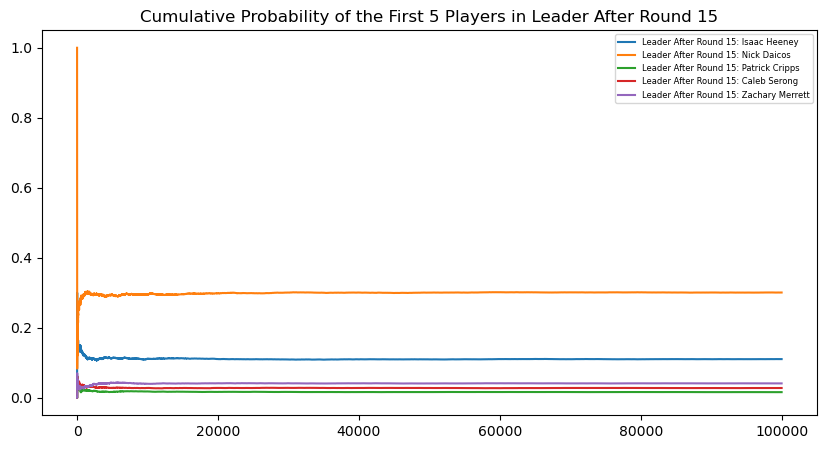

Probability of the first player in Leader After Round 15 is 0.15 after 10 samples
Probability of the first player in Leader After Round 15 is 0.18333333333333335 after 100 samples
Probability of the first player in Leader After Round 15 is 0.12308333333333332 after 1000 samples
Probability of the first player in Leader After Round 15 is 0.11139833333333343 after 10000 samples
Probability of the first player in Leader After Round 15 is 0.11066666666666651 after 20000 samples
Probability of the first player in Leader After Round 15 is 0.10947833333333354 after 30000 samples
Probability of the first player in Leader After Round 15 is 0.10974541666666682 after 40000 samples
Probability of the first player in Leader After Round 15 is 0.10965766666666639 after 50000 samples
Probability of the first player in Leader After Round 15 is 0.11055972222222164 after 60000 samples
Probability of the first player in Leader After Round 15 is 0.11025428571428485 after 70000 samples
Probability of the fi

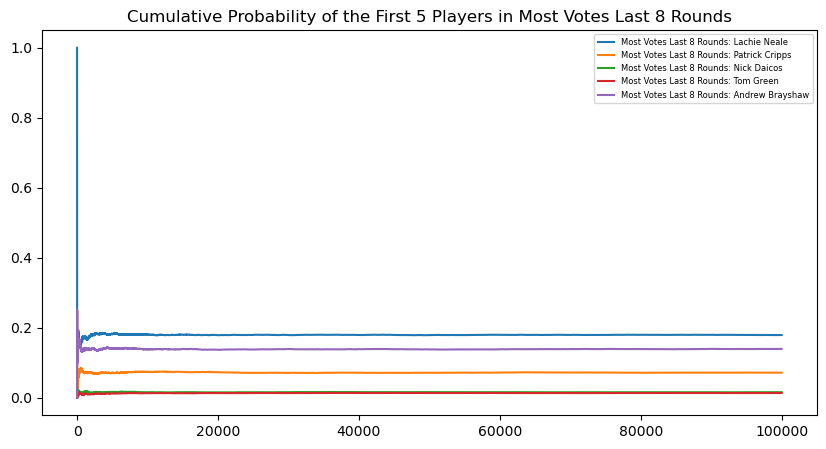

Probability of the first player in Most Votes Last 8 Rounds is 0.15 after 10 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.16833333333333336 after 100 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.17331666666666667 after 1000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.18092499999999964 after 10000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.17883047619047693 after 20000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.17938341269841232 after 30000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.17936988095237963 after 40000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.1791415714285707 after 50000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.17991019841269926 after 60000 samples
Probability of the first player in Most Votes Last 8 Rounds is 0.17960731292517215 after 70000 

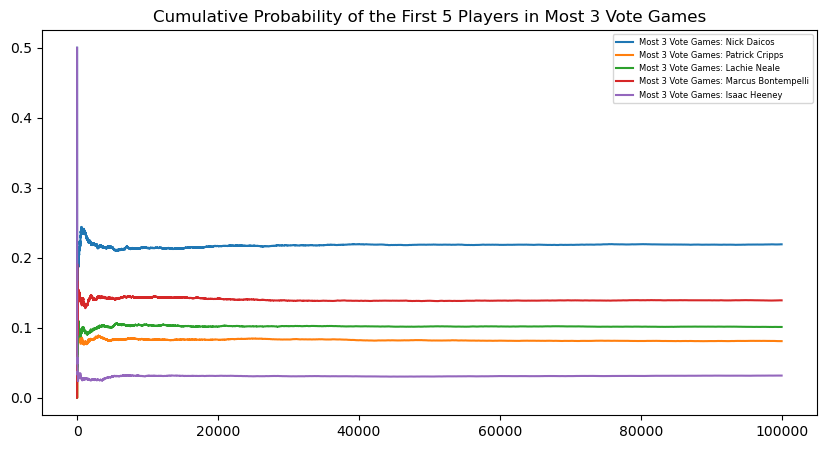

Probability of the first player in Most 3 Vote Games is 0.2 after 10 samples
Probability of the first player in Most 3 Vote Games is 0.18566666666666667 after 100 samples
Probability of the first player in Most 3 Vote Games is 0.23747063492063497 after 1000 samples
Probability of the first player in Most 3 Vote Games is 0.2139293650793647 after 10000 samples
Probability of the first player in Most 3 Vote Games is 0.21672851190476244 after 20000 samples
Probability of the first player in Most 3 Vote Games is 0.21759267195766838 after 30000 samples
Probability of the first player in Most 3 Vote Games is 0.21941604166666384 after 40000 samples
Probability of the first player in Most 3 Vote Games is 0.21878115873016105 after 50000 samples
Probability of the first player in Most 3 Vote Games is 0.2183829761904816 after 60000 samples
Probability of the first player in Most 3 Vote Games is 0.2184826247165613 after 70000 samples
Probability of the first player in Most 3 Vote Games is 0.2195024

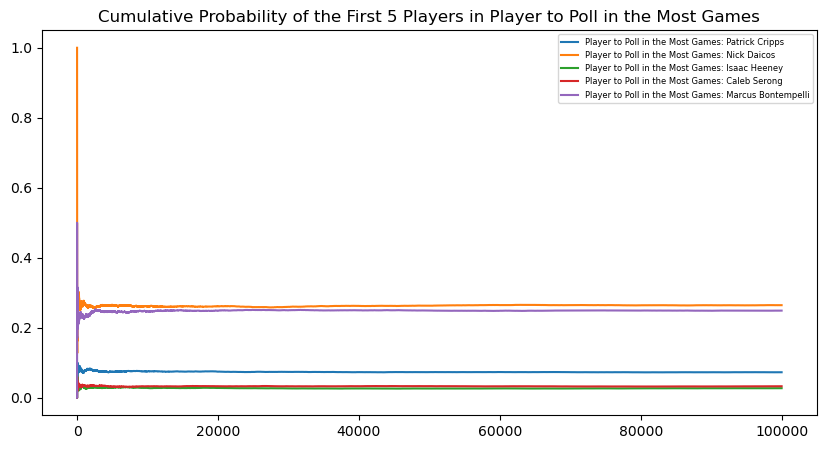

Probability of the first player in Player to Poll in the Most Games is 0.0 after 10 samples
Probability of the first player in Player to Poll in the Most Games is 0.08583333333333332 after 100 samples
Probability of the first player in Player to Poll in the Most Games is 0.07623333333333335 after 1000 samples
Probability of the first player in Player to Poll in the Most Games is 0.0757326190476192 after 10000 samples
Probability of the first player in Player to Poll in the Most Games is 0.07454511904761897 after 20000 samples
Probability of the first player in Player to Poll in the Most Games is 0.07396396825396802 after 30000 samples
Probability of the first player in Player to Poll in the Most Games is 0.0732673809523812 after 40000 samples
Probability of the first player in Player to Poll in the Most Games is 0.07326557142857203 after 50000 samples
Probability of the first player in Player to Poll in the Most Games is 0.07353261904761936 after 60000 samples
Probability of the first 

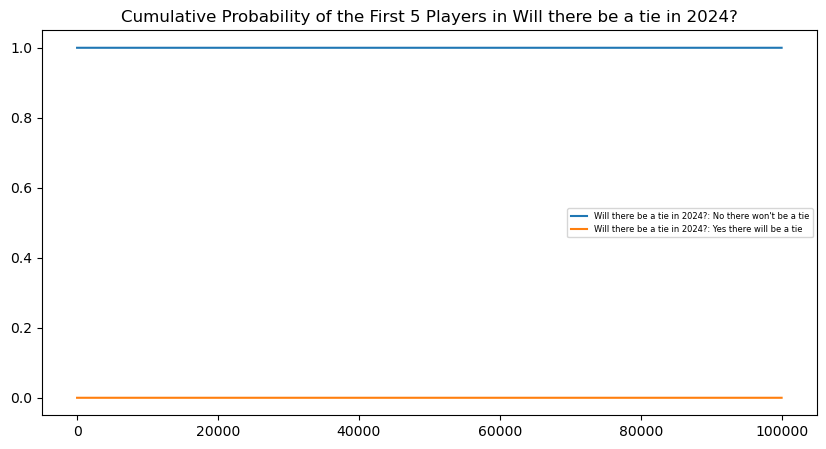

Probability of the first player in Will there be a tie in 2024? is 1.0 after 10 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 100 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 1000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 10000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 20000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 30000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 40000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 50000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 60000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 70000 samples
Probability of the first player in Will there be a tie in 2024? is 1.0 after 80000 samples
Proba

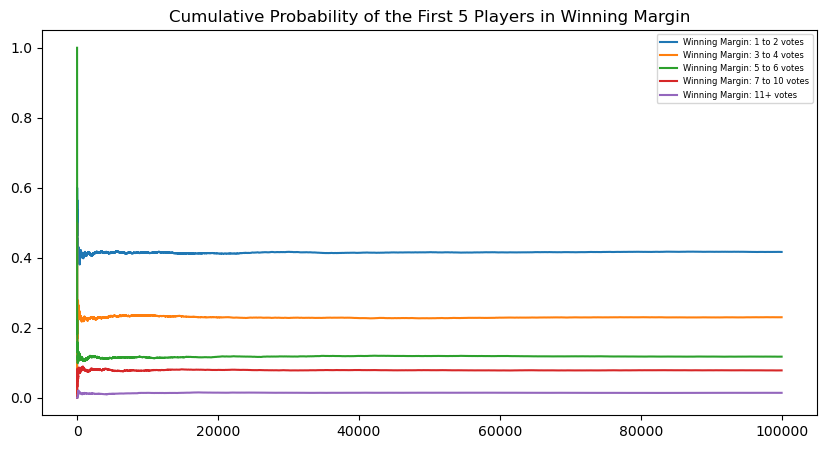

Probability of the first player in Winning Margin is 0.6 after 10 samples
Probability of the first player in Winning Margin is 0.44 after 100 samples
Probability of the first player in Winning Margin is 0.407 after 1000 samples
Probability of the first player in Winning Margin is 0.4146 after 10000 samples
Probability of the first player in Winning Margin is 0.41245 after 20000 samples
Probability of the first player in Winning Margin is 0.41696666666666665 after 30000 samples
Probability of the first player in Winning Margin is 0.4142 after 40000 samples
Probability of the first player in Winning Margin is 0.41584 after 50000 samples
Probability of the first player in Winning Margin is 0.41546666666666665 after 60000 samples
Probability of the first player in Winning Margin is 0.4159857142857143 after 70000 samples
Probability of the first player in Winning Margin is 0.416925 after 80000 samples
Probability of the first player in Winning Margin is 0.41714444444444443 after 90000 sampl

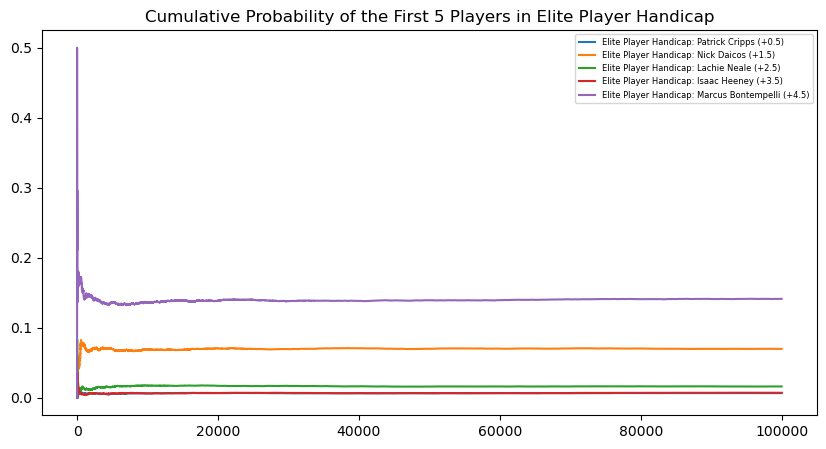

Probability of the first player in Elite Player Handicap is 0.0 after 10 samples
Probability of the first player in Elite Player Handicap is 0.0 after 100 samples
Probability of the first player in Elite Player Handicap is 0.006 after 1000 samples
Probability of the first player in Elite Player Handicap is 0.0063 after 10000 samples
Probability of the first player in Elite Player Handicap is 0.0066 after 20000 samples
Probability of the first player in Elite Player Handicap is 0.006466666666666667 after 30000 samples
Probability of the first player in Elite Player Handicap is 0.006475 after 40000 samples
Probability of the first player in Elite Player Handicap is 0.0064 after 50000 samples
Probability of the first player in Elite Player Handicap is 0.006716666666666667 after 60000 samples
Probability of the first player in Elite Player Handicap is 0.006542857142857143 after 70000 samples
Probability of the first player in Elite Player Handicap is 0.0067125 after 80000 samples
Probabili

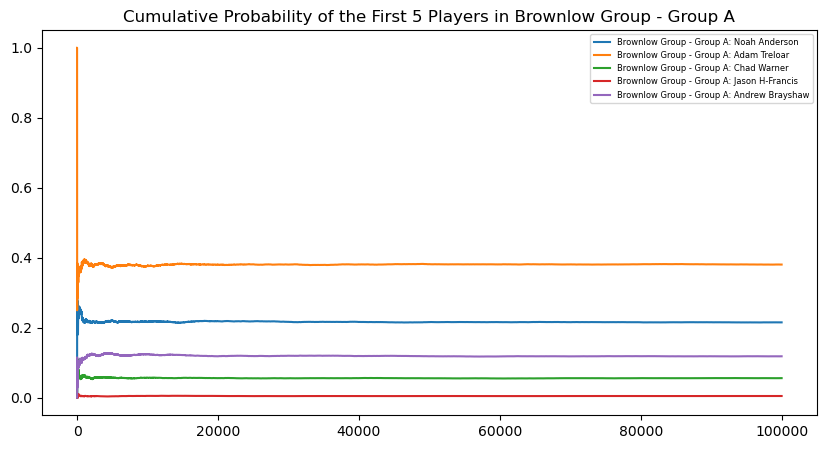

Probability of the first player in Brownlow Group - Group A is 0.2 after 10 samples
Probability of the first player in Brownlow Group - Group A is 0.21333333333333332 after 100 samples
Probability of the first player in Brownlow Group - Group A is 0.21733333333333338 after 1000 samples
Probability of the first player in Brownlow Group - Group A is 0.21645666666666652 after 10000 samples
Probability of the first player in Brownlow Group - Group A is 0.21886166666666712 after 20000 samples
Probability of the first player in Brownlow Group - Group A is 0.21691055555555508 after 30000 samples
Probability of the first player in Brownlow Group - Group A is 0.21654333333333262 after 40000 samples
Probability of the first player in Brownlow Group - Group A is 0.21626966666666714 after 50000 samples
Probability of the first player in Brownlow Group - Group A is 0.2160961111111124 after 60000 samples
Probability of the first player in Brownlow Group - Group A is 0.2160038095238115 after 70000 sa

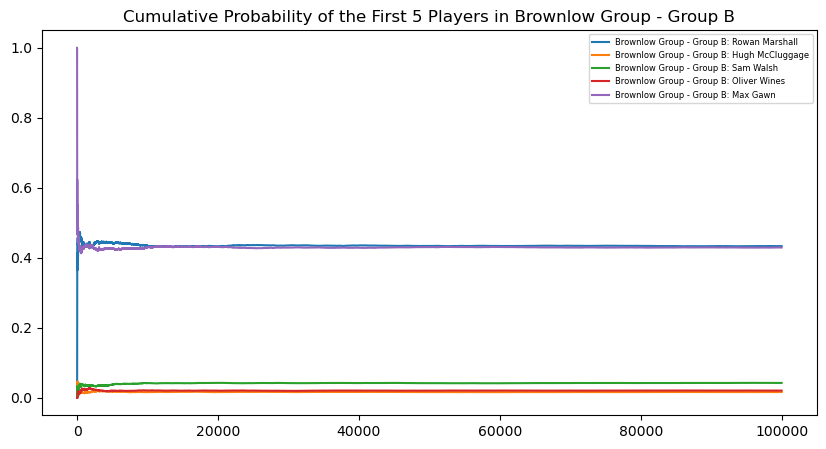

Probability of the first player in Brownlow Group - Group B is 0.13333333333333333 after 10 samples
Probability of the first player in Brownlow Group - Group B is 0.4183333333333333 after 100 samples
Probability of the first player in Brownlow Group - Group B is 0.4368333333333332 after 1000 samples
Probability of the first player in Brownlow Group - Group B is 0.4341166666666669 after 10000 samples
Probability of the first player in Brownlow Group - Group B is 0.4328891666666658 after 20000 samples
Probability of the first player in Brownlow Group - Group B is 0.4351550000000007 after 30000 samples
Probability of the first player in Brownlow Group - Group B is 0.43509125000000076 after 40000 samples
Probability of the first player in Brownlow Group - Group B is 0.4340019999999992 after 50000 samples
Probability of the first player in Brownlow Group - Group B is 0.43368499999999804 after 60000 samples
Probability of the first player in Brownlow Group - Group B is 0.4342983333333308 aft

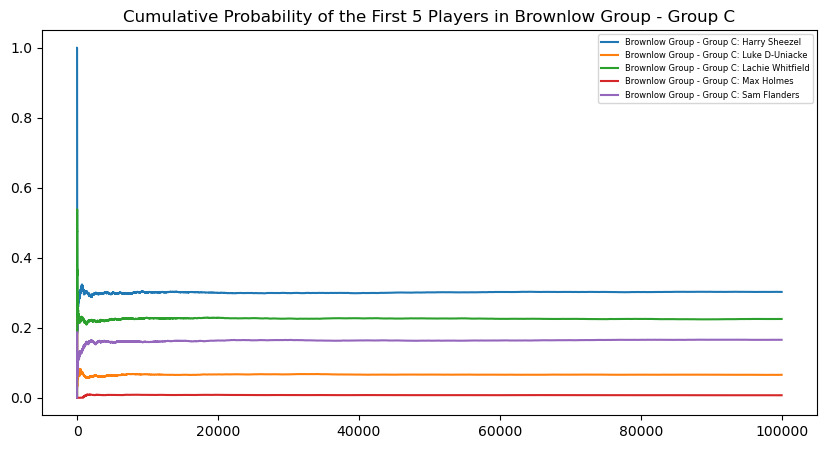

Probability of the first player in Brownlow Group - Group C is 0.3 after 10 samples
Probability of the first player in Brownlow Group - Group C is 0.29 after 100 samples
Probability of the first player in Brownlow Group - Group C is 0.2995333333333333 after 1000 samples
Probability of the first player in Brownlow Group - Group C is 0.3008566666666669 after 10000 samples
Probability of the first player in Brownlow Group - Group C is 0.2996366666666661 after 20000 samples
Probability of the first player in Brownlow Group - Group C is 0.2991922222222217 after 30000 samples
Probability of the first player in Brownlow Group - Group C is 0.29905458333333423 after 40000 samples
Probability of the first player in Brownlow Group - Group C is 0.3011556666666684 after 50000 samples
Probability of the first player in Brownlow Group - Group C is 0.3023011111111121 after 60000 samples
Probability of the first player in Brownlow Group - Group C is 0.3023947619047608 after 70000 samples
Probability of

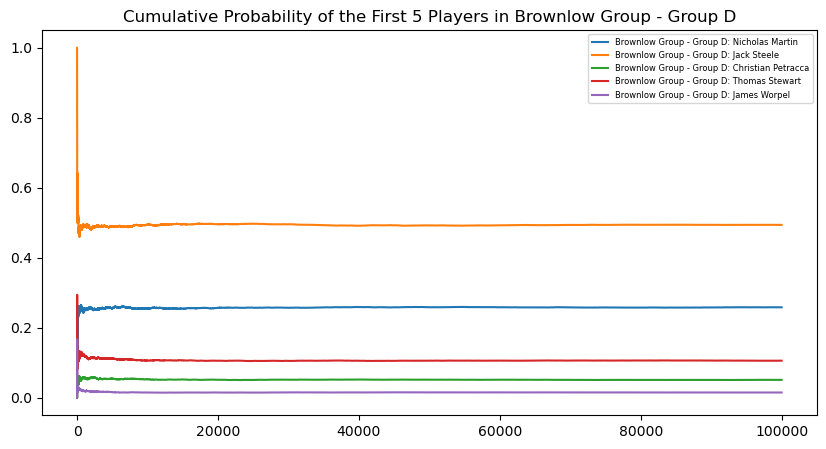

Probability of the first player in Brownlow Group - Group D is 0.15 after 10 samples
Probability of the first player in Brownlow Group - Group D is 0.23333333333333336 after 100 samples
Probability of the first player in Brownlow Group - Group D is 0.25483333333333336 after 1000 samples
Probability of the first player in Brownlow Group - Group D is 0.2550566666666667 after 10000 samples
Probability of the first player in Brownlow Group - Group D is 0.25710083333333317 after 20000 samples
Probability of the first player in Brownlow Group - Group D is 0.25706666666666556 after 30000 samples
Probability of the first player in Brownlow Group - Group D is 0.2591904166666671 after 40000 samples
Probability of the first player in Brownlow Group - Group D is 0.2586990000000015 after 50000 samples
Probability of the first player in Brownlow Group - Group D is 0.25855027777778006 after 60000 samples
Probability of the first player in Brownlow Group - Group D is 0.25830476190476287 after 70000 sa

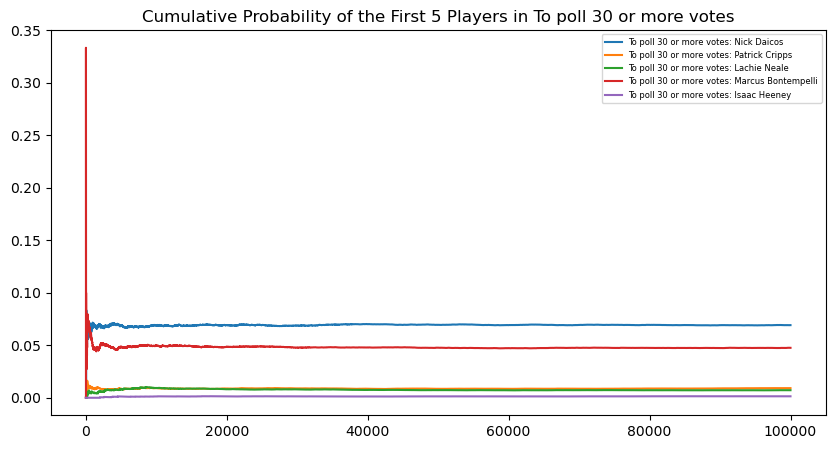

Probability of the first player in To poll 30 or more votes is 0.0 after 10 samples
Probability of the first player in To poll 30 or more votes is 0.06 after 100 samples
Probability of the first player in To poll 30 or more votes is 0.068 after 1000 samples
Probability of the first player in To poll 30 or more votes is 0.0688 after 10000 samples
Probability of the first player in To poll 30 or more votes is 0.0692 after 20000 samples
Probability of the first player in To poll 30 or more votes is 0.06883333333333333 after 30000 samples
Probability of the first player in To poll 30 or more votes is 0.0701 after 40000 samples
Probability of the first player in To poll 30 or more votes is 0.0695 after 50000 samples
Probability of the first player in To poll 30 or more votes is 0.0692 after 60000 samples
Probability of the first player in To poll 30 or more votes is 0.06932857142857143 after 70000 samples
Probability of the first player in To poll 30 or more votes is 0.06945 after 80000 sam

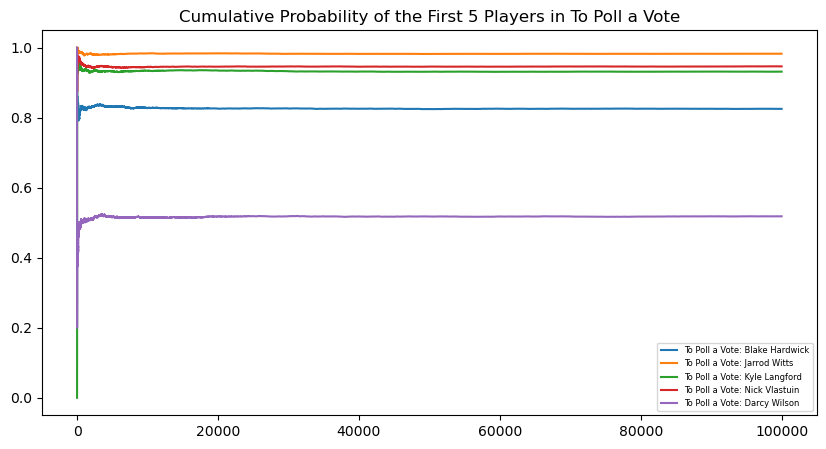

Probability of the first player in To Poll a Vote is 0.9 after 10 samples
Probability of the first player in To Poll a Vote is 0.83 after 100 samples
Probability of the first player in To Poll a Vote is 0.826 after 1000 samples
Probability of the first player in To Poll a Vote is 0.8279 after 10000 samples
Probability of the first player in To Poll a Vote is 0.8262 after 20000 samples
Probability of the first player in To Poll a Vote is 0.8266666666666667 after 30000 samples
Probability of the first player in To Poll a Vote is 0.8257 after 40000 samples
Probability of the first player in To Poll a Vote is 0.82488 after 50000 samples
Probability of the first player in To Poll a Vote is 0.82585 after 60000 samples
Probability of the first player in To Poll a Vote is 0.8258142857142857 after 70000 samples
Probability of the first player in To Poll a Vote is 0.825875 after 80000 samples
Probability of the first player in To Poll a Vote is 0.8257333333333333 after 90000 samples
Probability 

In [26]:
for bet_type in odds:
    first_5_columns = [column for column in cum_prob.columns if column.split(': ')[0] == bet_type][:5]

    if len(first_5_columns) == 0:
        continue

    # Increase figure size
    plt.figure(figsize=(10, 5))  # Adjust the width (12) and height (8) as needed

    # Plot the cumulative probability of the first 5 players
    plt.plot(cum_prob[first_5_columns])

    # Get the legend with smaller text size
    plt.legend(first_5_columns, fontsize=6)

    plt.title(f'Cumulative Probability of the First 5 Players in {bet_type}')

    # Show the plot
    plt.show()

    for i in [9, 99, 999, 9999, 19999, 29999, 39999, 49999, 59999, 69999, 79999, 89999, 99999]:
        print(f'Probability of the first player in {bet_type} is {cum_prob[first_5_columns[0]].iloc[i]} after {i+1} samples')
